In [2]:
import importlib
import pandas as pd
import analysis_functions as af
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import stats
import os
import pickle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

In [12]:
# Load the ctl data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_ctldata.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl = pickle.load(f)
    data_ctl.pop(13) # no speed and lick in this animal's tst data
# process the speed and pupil data
for ani in data_ctl:
    # data_ctl[ani]['pupil'] = (data_ctl[ani]['pupil'] - np.nanmedian(data_ctl[ani]['pupil'])) / np.nanstd(data_ctl[ani]['pupil']) # normalise the pupil data
    data_ctl[ani]['speed'] = data_ctl[ani]['speed'] - np.percentile(data_ctl[ani]['speed'], 10)  # speed - percentile(speed)


# Load the tst data 
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_tstdata.pkl")
with open(desktop_path, 'rb') as f:
    data_tst = pickle.load(f)
    data_tst.pop(13) # no speed and lick data in this animal
# process the speed and pupil data
for ani in data_tst:
    # data_tst[ani]['pupil'] = (data_tst[ani]['pupil'] - np.nanmedian(data_tst[ani]['pupil'])) / np.nanstd(data_tst[ani]['pupil']) # normalise the pupil data
    data_tst[ani]['speed'] = data_tst[ani]['speed'] - np.percentile(data_tst[ani]['speed'], 10)  # speed - percentile(speed)


In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

max_valid = 5
min_interval = 100   # refractory period in samples

for ani in data_tst_full:
    lick_onsets_tst[ani] = []

    lick_signal_raw = np.clip(data_tst_full[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = gaussian_filter1d(lick_signal_raw, sigma=0.1)  # optional smoothing

    trial_start_indices = data_tst_full[ani]['trial_start_indices']

    # iterate over all trials
    for tri in range(len(trial_start_indices) - 1):
        start = trial_start_indices[tri]
        end = trial_start_indices[tri + 1]
        segment = lick_signal[start:end]
        

        threshold = 0.4

        # compute per-trial threshold
        # threshold = np.median(segment) + 3 * np.std(segment)

        # find threshold crossings
        above = segment > threshold
        crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

        # convert local indices to absolute indices
        if len(crossings) > 0:
            # enforce refractory period (in absolute frame)
            abs_cross = start + crossings
            if len(abs_cross) > 0:
                filtered = [abs_cross[0]]
                for idx in abs_cross[1:]:
                    if idx - filtered[-1] >= min_interval:
                        filtered.append(idx)
                lick_onsets_tst[ani].extend(filtered)


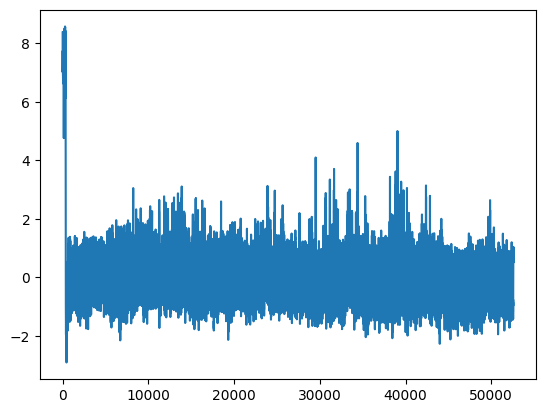

In [6]:
plt.plot(data_ctl[4]['pupil'])

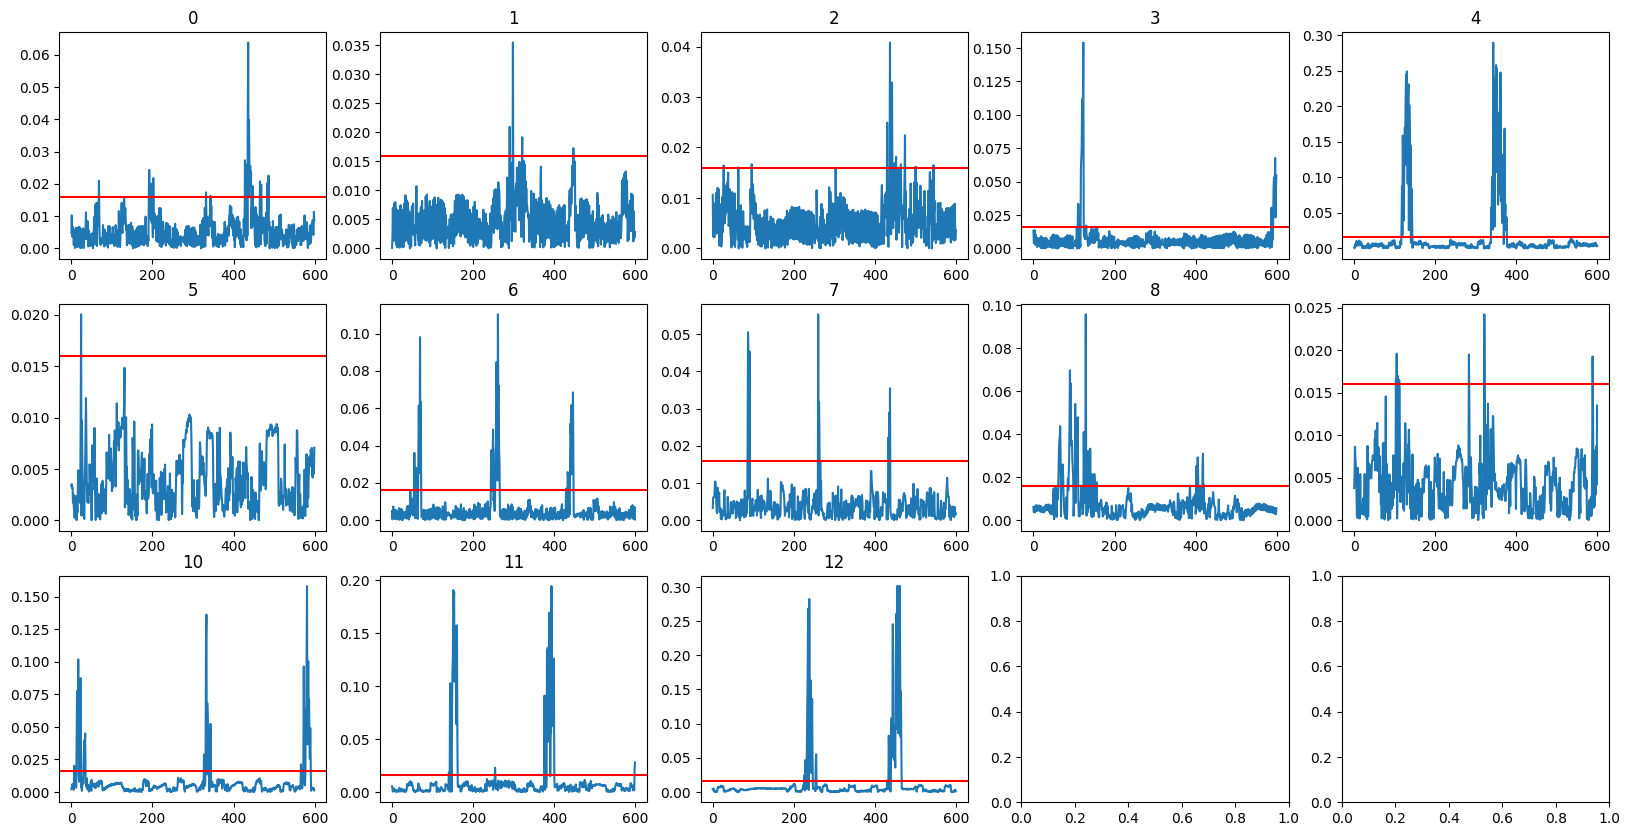

In [527]:
lick_onsets_ctl = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten() 
for ani in data_ctl:
    lick_onsets_ctl[ani] = []
    max_valid =  0.5  # upper bound for real licks vs animal pushing licktube
    lick_signal_raw = np.clip(data_ctl[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = np.abs(lick_signal_raw - np.median(lick_signal_raw))
    axes[ani].plot(lick_signal[31000:31600])
    axes[ani].set_title(f'{ani}')

    threshold = 0.016
    axes[ani].axhline(threshold,c='red')
    above = lick_signal > threshold
    lick_onsets_ctl[ani] = np.where(above)[0]

# calculate the lick_record and lick_rate
lick_record_ctl = {}
for ani in data_ctl:
    lick_record_ctl[ani] = np.zeros(data_ctl[ani]['lick'].shape[0])
    for num in lick_onsets_ctl[ani]:
        lick_record_ctl[ani][num] = 1

lick_rate_ctl = {}
window_frames = 7
for ani in data_ctl:
    lick_series = pd.Series(lick_record_ctl[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum() 
    lick_rate_ctl[ani] = np.array(lick_count)   # Convert to licks/sec (since window is 1 sec, no need to change)

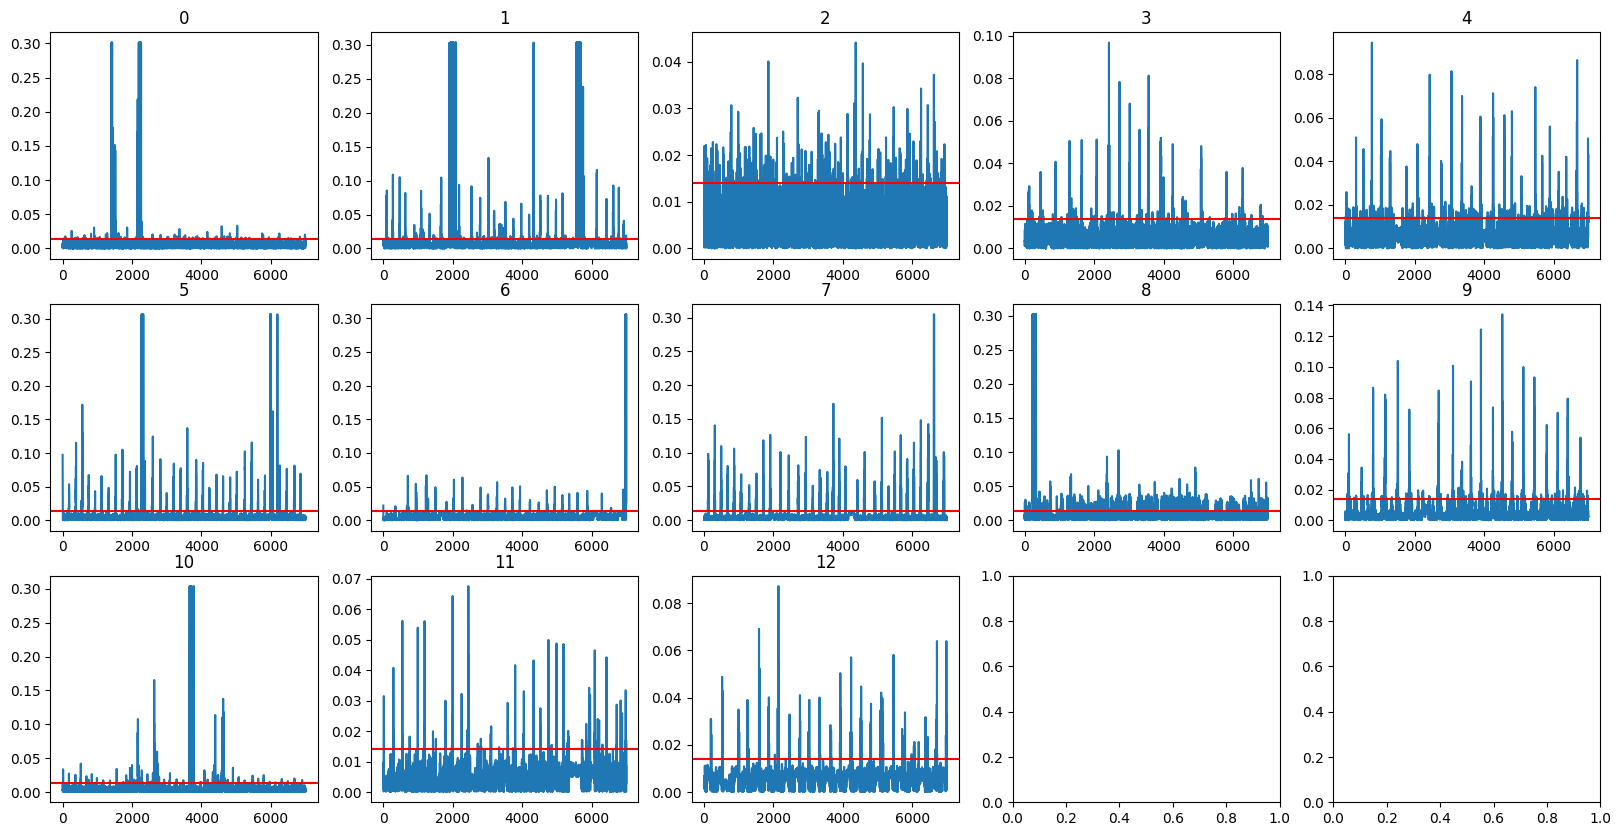

In [554]:
lick_onsets_tst = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten() 
for ani in data_tst:
    lick_onsets_tst[ani] = []
    max_valid =  0.5  # upper bound for real licks vs animal pushing licktube
    lick_signal_raw = np.clip(data_tst[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = np.abs(lick_signal_raw - np.median(lick_signal_raw))
    axes[ani].plot(lick_signal[9000:16000])
    axes[ani].set_title(f'{ani}')

    threshold = 0.014
    axes[ani].axhline(threshold,c='red')
    above = lick_signal > threshold
    lick_onsets_tst[ani] = np.where(above)[0]

# calculate the lick_record and lick_rate
lick_record_tst = {}
for ani in data_tst:
    lick_record_tst[ani] = np.zeros(data_tst[ani]['lick'].shape[0])
    for num in lick_onsets_tst[ani]:
        lick_record_tst[ani][num] = 1

lick_rate_tst = {}
window_frames = 7
for ani in data_tst:
    lick_series = pd.Series(lick_record_tst[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum() 
    lick_rate_tst[ani] = np.array(lick_count)   # Convert to licks/sec (since window is 1 sec, no need to change)

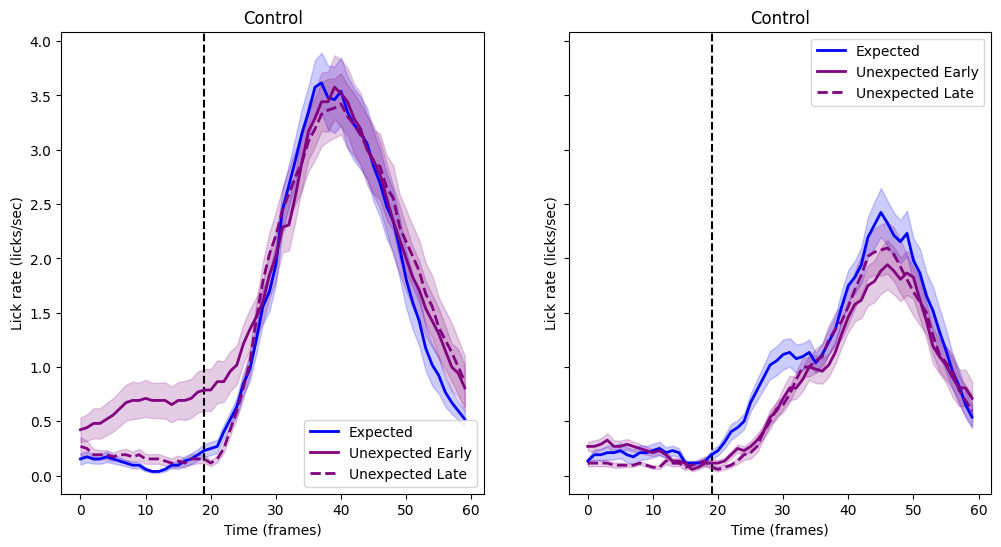

In [553]:
#ctl
unexp_data = {}
for ani in data_ctl:
    unexp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_data[ani].append(lick_rate_ctl[ani][data_ctl[ani]['reward_indices'][trial]])
exp_data = {}
for ani in data_ctl:
    exp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][:4]:
        exp_data[ani].append(lick_rate_ctl[ani][data_ctl[ani]['reward_indices'][trial-1]])
unexp_late_data = {}
for ani in data_ctl:
    unexp_late_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_late_data[ani].append(lick_rate_ctl[ani][data_ctl[ani]['reward_indices'][trial-1]])
exp_color = 'blue'
unexp_color = 'purple'
# control
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in data_ctl]),axis = 1)
exp = np.mean(np.stack([exp_data[ani] for ani in data_ctl]),axis = 1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in data_ctl]),axis = 1)

x_vals = np.arange(exp.shape[1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].axvline(19, linestyle='--', color='k')
af.plot_shaded_error(axes[0], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[0], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[0], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[0].set_title('Control')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Lick rate (licks/sec)')
axes[0].legend()

# tst
unexp_data = {}
for ani in data_tst:
    unexp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_data[ani].append(lick_rate_tst[ani][data_tst[ani]['reward_indices'][trial]])
exp_data = {}
for ani in data_tst:
    exp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][:4]:
        exp_data[ani].append(lick_rate_tst[ani][data_tst[ani]['reward_indices'][trial-1]])
unexp_late_data = {}
for ani in data_tst:
    unexp_late_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_late_data[ani].append(lick_rate_tst[ani][data_tst[ani]['reward_indices'][trial-1]])
exp_color = 'blue'
unexp_color = 'purple'
# test
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in data_tst]), axis=1)
exp = np.mean(np.stack([exp_data[ani] for ani in data_tst]), axis=1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in data_tst]), axis=1)

x_vals = np.arange(exp.shape[1])
axes[1].axvline(19, linestyle='--', color='k')
af.plot_shaded_error(axes[1], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[1], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[1], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[1].set_title('Control')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Lick rate (licks/sec)')
axes[1].legend()


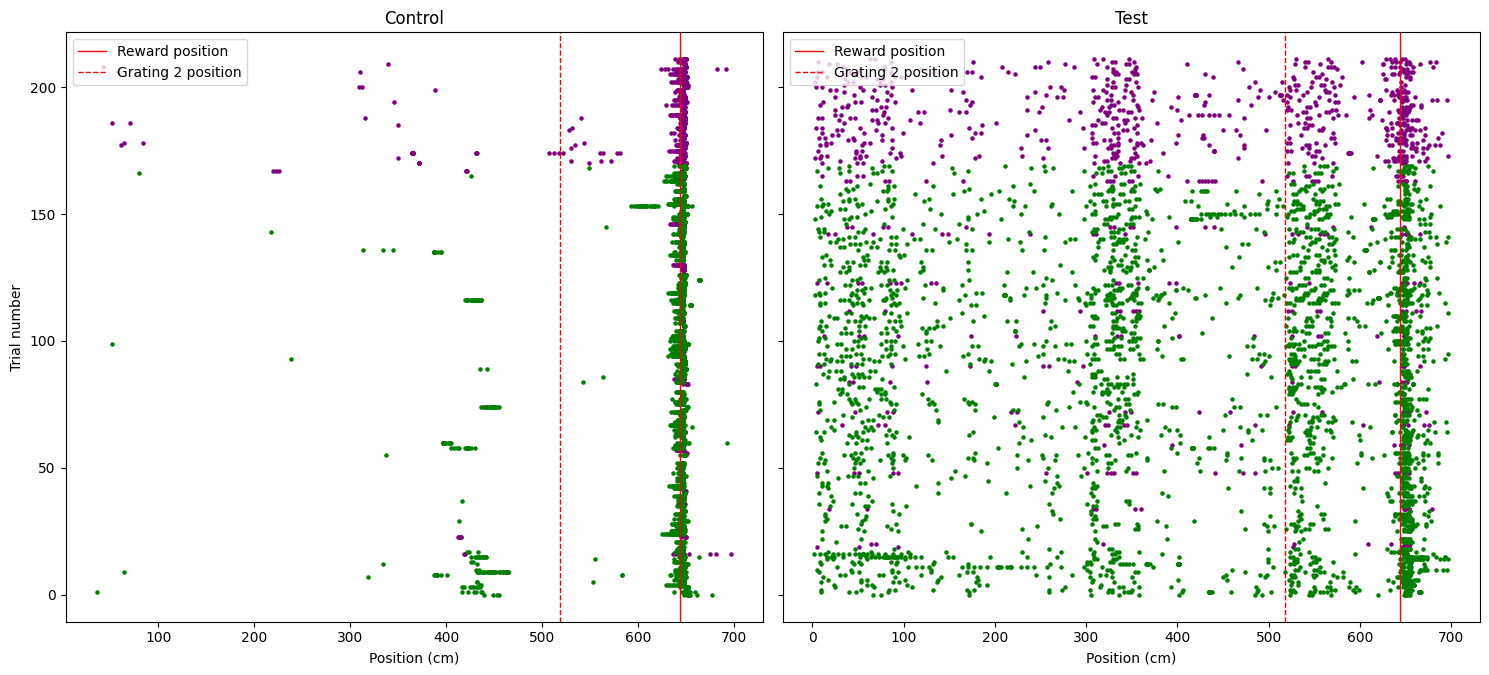

In [551]:
plot_lick_data(4)

In [ ]:
fps = 7.5
pre_frames = 20
post_frames = int(round(2 * fps))
reward_frame = 20
start_frame = reward_frame - pre_frames
end_frame = reward_frame + post_frames


def compute_unexp_exp_rw(data_group, group_name):
    unexp_rw = {}
    exp_rw = {}
    for ani in data_group:
        unexp_rw[ani] = []
        exp_rw[ani] = []
        for trial in data_group[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_group[ani]['reward_indices'][trial])
        if group_name == 'control':
            for trial in data_group[ani]['unpred_trials']['gr_2']:
                exp_rw[ani].append(data_group[ani]['reward_indices'][trial - 1])
        elif group_name == 'test':
            for trial in data_group[ani]['unpred_trials']['gr_2']:
                exp_rw[ani].append(data_group[ani]['reward_indices'][trial-1])
    return unexp_rw, exp_rw

unexp_rw_ctl, exp_rw_ctl = compute_unexp_exp_rw(data_ctl, 'control')
unexp_rw_tst, exp_rw_tst = compute_unexp_exp_rw(data_tst, 'test')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for num, (lick_record, unexp_rw, exp_rw) in enumerate([
    (lick_record_ctl, unexp_rw_ctl, exp_rw_ctl),
    (lick_record_tst, unexp_rw_tst, exp_rw_tst)
]):
    results = []
    all_animals = [1,3,4,5,6,7,8,9,10,11,12]
    for ani in all_animals:
        arr = lick_record[ani][exp_rw[ani][6:11]][:, start_frame:end_frame]
        first_lick_exp_B = []
        for row in arr:
            ones = np.where(row == 1)[0]
            first_lick_exp_B.append(pre_frames - ones[0] if len(ones) > 0 else -post_frames)
        arr = lick_record[ani][unexp_rw[ani][:5]][:, start_frame:end_frame]
        first_lick_unexp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]
            first_lick_unexp_X.append(pre_frames - ones[0] if len(ones) > 0 else -post_frames)
        if num == 0:
            arr = lick_record[ani][unexp_rw[ani][6:11]][:, start_frame:end_frame]
        else:
            arr = lick_record[ani][unexp_rw[ani][6:11]][:, start_frame:end_frame]
        first_lick_exp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]
            first_lick_exp_X.append(pre_frames - ones[0] if len(ones) > 0 else -post_frames)
        results.append([
            np.mean(first_lick_exp_B),
            np.mean(first_lick_unexp_X),
            np.mean(first_lick_exp_X)
        ])
    results = np.array(results) / fps
    colors = ['gray', 'red', 'blue']
    x_positions = [1, 2, 3]
    for i, xpos in enumerate(x_positions):
        ax[num].scatter(
            np.full(results.shape[0], xpos), results[:, i],
            facecolors='none', edgecolors=colors[i], s=60,
            linewidth=1.5, zorder=3
        )
    for animal in results:
        ax[num].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2)
    for i in range(results.shape[1]):
        mean_val = np.mean(results[:, i])
        ax[num].hlines(mean_val, i + 0.8, i + 1.2, color='black', linewidth=2)
    pairs = [(0, 1), (0, 2), (1, 2)]
    labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
    pvals = []
    for (i, j), label in zip(pairs, labels):
        stat, p = wilcoxon(results[:, i], results[:, j])
        pvals.append(p)
    ax[num].set_xticks([1, 2, 3])
    ax[num].set_ylim([-2,2])
    ax[num].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
    ax[num].spines['top'].set_visible(False)
    ax[num].spines['right'].set_visible(False)
    i, j = 0, 1
    x = (i + 1 + j + 1) / 2
    y = max(results[:, i].max(), results[:, j].max()) + 0.1
    ax[num].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
    i, j = 1, 2
    x = (i + 1 + j + 1) / 2
    y = max(results[:, i].max(), results[:, j].max()) + 0.1
    ax[num].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
    ax[num].set_ylabel('Latency (s)')

ax[0].set_title('Lick Latency (Control)')
ax[1].set_title('Lick Latency (Test)')
plt.tight_layout()
plt.show()


Lick Data

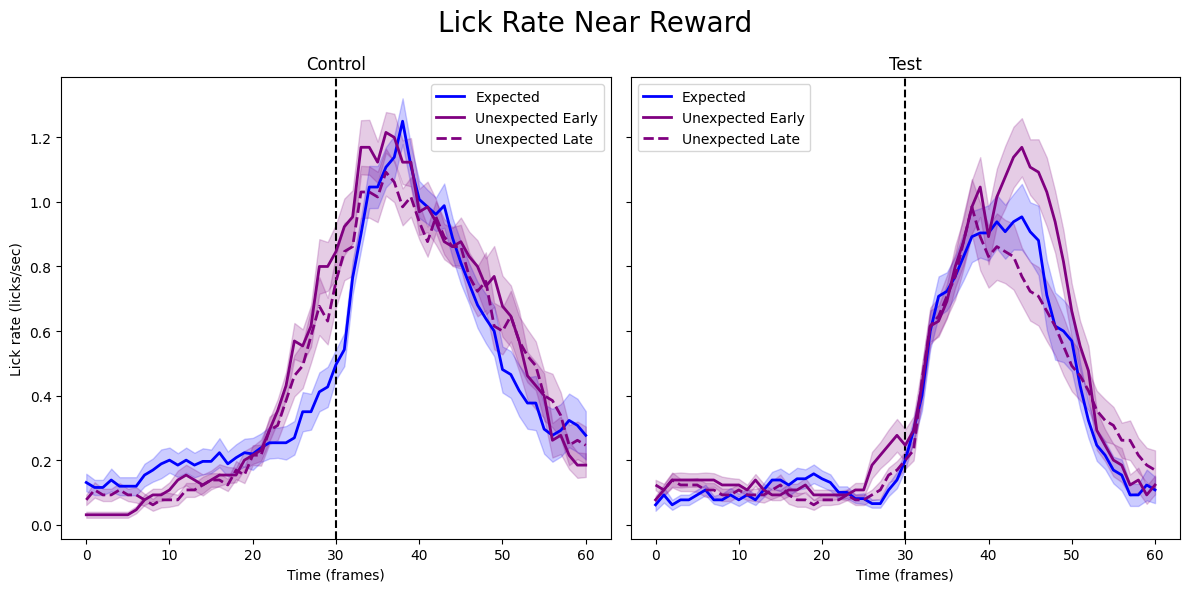

In [66]:
# Figure 

def process_group(data_group):
    lick_onsets = {}
    unexp_tri = {}
    unexp_late_tri = {}
    exp_tr = {}
    threshold = 0.21

    frame_rate = 7
    window_frames = 7
    max_valid = 0.5
    min_interval = 0.9
    lick_record = {}
    lick_rate = {}
    for ani in data_group:
        trunc_pos = np.floor(data_group[ani]['real_position'] * 10) / 10
        rew_trigger = np.where((trunc_pos[:-1] != 4.6) & (trunc_pos[1:] == 4.6))[0] + 1
        data_group[ani]['reward_indices'] = np.array([
            np.arange(idx - 30, idx + 31)
            for idx in rew_trigger if idx >= 30 and idx < len(trunc_pos) - 30
        ])
        unexp_tri[ani] = data_group[ani]['unpred_trials']['gr_2'][:5]
        unexp_late_tri[ani] = data_group[ani]['unpred_trials']['gr_2'][6:11]
        exp_tr[ani] = [
            item - 1 for item in data_group[ani]['unpred_trials']['gr_2'][6:11]
            if item - 1 not in data_group[ani]['unpred_trials']['gr_2']
        ]
        lick_onsets[ani] = []
        lick_signal = np.clip(data_group[ani]['lick'], a_min=None, a_max=max_valid)
        above = lick_signal > threshold
        crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1
        if len(crossings) > 0:
            lick_onsets[ani] = [crossings[0]]
            for idx in crossings[1:]:
                if idx - lick_onsets[ani][-1] >= min_interval:
                    lick_onsets[ani].append(idx)
            lick_onsets[ani] = np.array(lick_onsets[ani])
        else:
            lick_onsets[ani] = np.array([])
        lick_record[ani] = np.zeros(data_group[ani]['lick'].shape[0])
        lick_record[ani][lick_onsets[ani].astype(int)] = 1
        lick_series = pd.Series(lick_record[ani])
        lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()
        lick_rate[ani] = np.array(lick_count)
    exp_data = np.array([
        np.mean(lick_rate[a][data_group[a]['reward_indices'][exp_tr[a]]], axis=0)
        for a in range(len(lick_rate))
    ])
    unexp_data = np.array([
        np.mean(lick_rate[a][data_group[a]['reward_indices'][unexp_tri[a]]], axis=0)
        for a in range(len(lick_rate))
    ])
    unexp_late_data = np.array([
        np.mean(lick_rate[a][data_group[a]['reward_indices'][unexp_late_tri[a]]], axis=0)
        for a in range(len(lick_rate))
    ])
    return exp_data, unexp_data, unexp_late_data, lick_record

exp_color = 'blue'
unexp_color = 'purple'

exp_ctl, unexp_ctl, unexp_late_ctl, lick_record_ctl = process_group(data_ctl)
exp_tst, unexp_tst, unexp_late_tst, lick_record_tst = process_group(data_tst)
x_vals = np.arange(exp_ctl.shape[1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[0], x_vals, exp_ctl, color=exp_color, label='Expected')
af.plot_shaded_error(axes[0], x_vals, unexp_ctl, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[0], x_vals, unexp_late_ctl, color=unexp_color, label='Unexpected Late', style='dash')
axes[0].set_title('Control')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Lick rate (licks/sec)')
axes[0].legend()
axes[1].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[1], x_vals, exp_tst, color=exp_color, label='Expected')
af.plot_shaded_error(axes[1], x_vals, unexp_tst, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[1], x_vals, unexp_late_tst, color=unexp_color, label='Unexpected Late', style='dash')
axes[1].set_title('Test')
axes[1].set_xlabel('Time (frames)')
axes[1].legend()
fig.suptitle('Lick Rate Near Reward', fontsize = 20)
plt.tight_layout()
plt.show()


In [538]:
def plot_lick_data(ani):  # function that plot lick raster
    ani_positions = data_ctl[ani]['real_position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_ctl[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_ctl[ani]['trial_start_indices']) - 1:   
            trial_end = data_ctl[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_ctl[ani]['real_position'])
        for num, lick in enumerate(lick_record_ctl[ani][trial_start:trial_end]):   # num is the index in [trial_start:trial_end]
            if lick == 1 and i in data_ctl[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_ctl[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    axes[0].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[0].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[0].axvline(x=4.6*700/5, color='red', linestyle='-', linewidth=1, label='Reward position')
    axes[0].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1, label='Grating 2 position')
    axes[0].legend(loc='upper left')
    axes[0].set_title('Control')
    axes[0].set_xlabel('Position (cm)')
    axes[0].set_ylabel('Trial number')
    fig.suptitle('')

    ani_positions = data_tst[ani]['real_position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_tst[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_tst[ani]['trial_start_indices']) - 1:   
            trial_end = data_tst[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_tst[ani]['real_position'])
        for num, lick in enumerate(lick_record_tst[ani][trial_start:trial_end]):   # num is the index
            if lick == 1 and i in data_tst[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_tst[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    axes[1].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[1].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[1].axvline(x=4.6*700/5, color='red', linestyle='-', linewidth=1, label='Reward position')
    axes[1].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1, label='Grating 2 position')
    axes[1].legend(loc='upper left')
    axes[1].set_title('Test')
    axes[1].set_xlabel('Position (cm)')
    plt.tight_layout()
    plt.show()

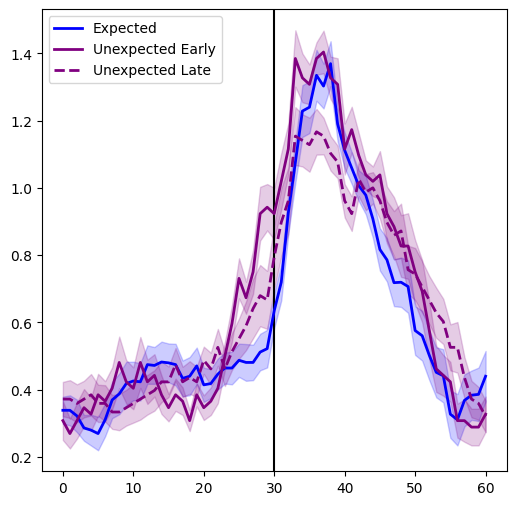

In [56]:
# left 
lick_onsets = {}
unexp_tri = {}
unexp_late_tri = {}
exp_tr = {}
unexp_color = 'purple'
exp_color = 'blue'
threshold = 0.205
for ani in data_ctl:
    trunc_pos = np.floor(data_ctl[ani]['real_position'] * 10) / 10
    rew_trigger = np.where((trunc_pos[:-1] != 4.6) & (trunc_pos[1:] == 4.6))[0] + 1
    data_ctl[ani]['reward_indices'] = np.array([np.arange(idx-30, idx+31) for idx in rew_trigger if idx >= 30 and idx < len(trunc_pos)-30])

    unexp_tri[ani] = data_ctl[ani]['unpred_trials']['gr_2'][:4]
    unexp_late_tri[ani] = data_ctl[ani]['unpred_trials']['gr_2'][6:12]
    exp_tr[ani] = [item - 1 for item in data_ctl[ani]["unpred_trials"]['gr_2'][6:12] if item - 1 not in data_ctl[ani]['unpred_trials']['gr_2']]

    lick_onsets[ani] = []
    lick_signal = data_ctl[ani]['lick']
    max_valid =  0.5 # upper bound for real licks vs animal pushing licktube
    lick_signal = np.clip(lick_signal, a_min=None, a_max=max_valid)
    above = lick_signal > threshold
    min_interval = 0.9  #  refractory period
    crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1
    if len(crossings) > 0:
        lick_onsets[ani] = [crossings[0]]
        for idx in crossings[1:]:
            if idx - lick_onsets[ani][-1] >= min_interval:
                lick_onsets[ani].append(idx)
        lick_onsets[ani] = np.array(lick_onsets[ani])
    else:
        lick_onsets[ani] = np.array([])


lick_record_ctl = {}
for ani in data_ctl:
    lick_record_ctl[ani] = np.zeros(data_ctl[ani]['lick'].shape[0])
    lick_record_ctl[ani][lick_onsets[ani]] = 1

lick_rate_ctl = {}
frame_rate = 7
window_frames = 7 
for ani in data_ctl:
    lick_series = pd.Series(lick_record_ctl[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()  # Rolling sum over 1s window
    lick_rate_ctl[ani] = np.array(lick_count)   # Convert to licks/sec (since window is 1 sec, no need to change)


exp_data  = np.array([np.mean(lick_rate_ctl[a][data_ctl[a]['reward_indices'][exp_tr[a]]], axis=0) for a in range(len(lick_rate_ctl))])
unexp_data = np.array([np.mean(lick_rate_ctl[a][data_ctl[a]['reward_indices'][unexp_tri[a]]], axis=0) for a in range(len(lick_rate_ctl))])
unexp_late_data = np.array([np.mean(lick_rate_ctl[a][data_ctl[a]['reward_indices'][unexp_late_tri[a]]], axis=0) for a in range(len(lick_rate_ctl))])

x_vals = np.arange(exp_data.shape[1])  
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.axvline(30, linestyle='-', color='k')

af.plot_shaded_error(ax, x_vals, exp_data, color=exp_color, label='Expected')
af.plot_shaded_error(ax, x_vals, unexp_data, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(ax, x_vals, unexp_late_data, color=unexp_color, label='Unexpected Late', style='dash')

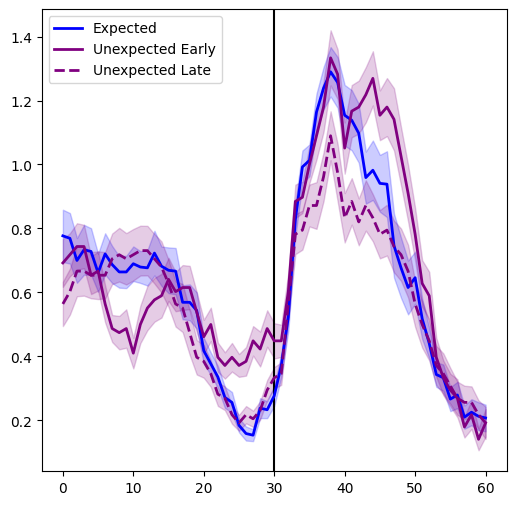

In [ ]:
# right
lick_onsets = {}
unexp_tri = {}
unexp_late_tri = {}
exp_tr = {}
unexp_color = 'purple'
exp_color = 'blue'
threshold = 0.205
for ani in data_tst:
    trunc_pos = np.floor(data_tst[ani]['real_position'] * 10) / 10
    rew_trigger = np.where((trunc_pos[:-1] != 4.6) & (trunc_pos[1:] == 4.6))[0] + 1
    data_tst[ani]['reward_indices'] = np.array([np.arange(idx-30, idx+31) for idx in rew_trigger if idx >= 30 and idx < len(trunc_pos)-30])

    unexp_tri[ani] = data_tst[ani]['unpred_trials']['gr_2'][:6]
    unexp_late_tri[ani] = data_tst[ani]['unpred_trials']['gr_2'][6:12]
    exp_tr[ani] = [item - 1 for item in data_tst[ani]["unpred_trials"]['gr_2'][6:12] if item - 1 not in data_tst[ani]['unpred_trials']['gr_2']]

    lick_onsets[ani] = []
    lick_signal = data_tst[ani]['lick']
    max_valid =  0.5 # upper bound for real licks vs animal pushing licktube
    lick_signal = np.clip(lick_signal, a_min=None, a_max=max_valid)
    above = lick_signal > threshold
    min_interval = 0.9  #  refractory period
    crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1
    if len(crossings) > 0:
        lick_onsets[ani] = [crossings[0]]
        for idx in crossings[1:]:
            if idx - lick_onsets[ani][-1] >= min_interval:
                lick_onsets[ani].append(idx)
        lick_onsets[ani] = np.array(lick_onsets[ani])
    else:
        lick_onsets[ani] = np.array([])


lick_record_tst = {}
for ani in data_tst:
    lick_record_tst[ani] = np.zeros(data_tst[ani]['lick'].shape[0])
    lick_record_tst[ani][lick_onsets[ani]] = 1

lick_rate_ctl = {}
frame_rate = 7
window_frames = 7 
for ani in data_tst:
    lick_series = pd.Series(lick_record_tst[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()  # Rolling sum over 1s window
    lick_rate_ctl[ani] = np.array(lick_count)   # Convert to licks/sec (since window is 1 sec, no need to change)


exp_data  = np.array([np.mean(lick_rate_ctl[a][data_tst[a]['reward_indices'][exp_tr[a]]], axis=0) for a in range(len(lick_rate_ctl))])
unexp_data = np.array([np.mean(lick_rate_ctl[a][data_tst[a]['reward_indices'][unexp_tri[a]]], axis=0) for a in range(len(lick_rate_ctl))])
unexp_late_data = np.array([np.mean(lick_rate_ctl[a][data_tst[a]['reward_indices'][unexp_late_tri[a]]], axis=0) for a in range(len(lick_rate_ctl))])

x_vals = np.arange(exp_data.shape[1])  
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.axvline(30, linestyle='-', color='k')

af.plot_shaded_error(ax, x_vals, exp_data, color=exp_color, label='Expected')
af.plot_shaded_error(ax, x_vals, unexp_data, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(ax, x_vals, unexp_late_data, color=unexp_color, label='Unexpected Late', style='dash')

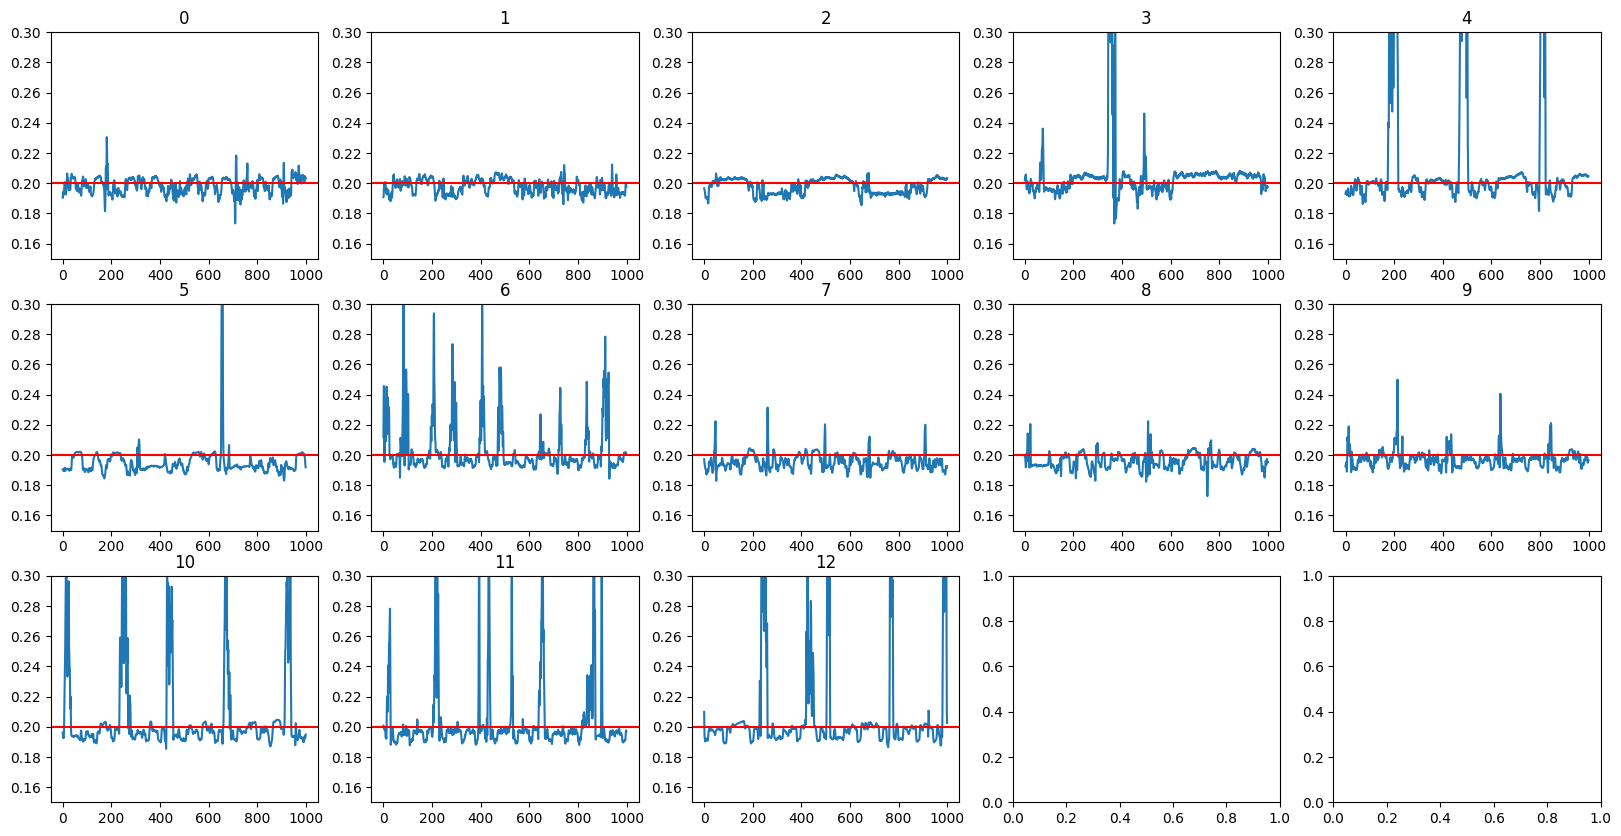

In [712]:
# Process&visualise the lick data (ctl)

sample_rate = 7.5
max_lick_rate = 7.5
lick_onsets_ctl = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten() 


# threshold_list = [0.209]

for ani in data_ctl:
    lick_onsets_ctl[ani] = []
    max_valid =  0.5  # upper bound for real licks vs animal pushing licktube
    lick_signal = np.clip(data_ctl[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = gaussian_filter1d(lick_signal, sigma= 1, axis=0)
    threshold = 0.2
    # threshold = threshold_list[ani]
    axes[ani].plot(lick_signal[6000:7000])
    # axes[ani].plot(lick_signal)
    axes[ani].axhline(threshold, color='red')
    axes[ani].set_ylim([0.15,0.3])
    axes[ani].set_title(f'{ani}')
    above = lick_signal > threshold
    min_interval = 0.9 #  refractory period
    crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1  
    if len(crossings) > 0:
        lick_onsets_ctl[ani] = [crossings[0]]
        for idx in crossings[1:]:
            if idx - lick_onsets_ctl[ani][-1] >= min_interval:
                lick_onsets_ctl[ani].append(idx)
        lick_onsets_ctl[ani] = np.array(lick_onsets_ctl[ani])
    else:
        lick_onsets_ctl[ani] = np.array([])

# calculate the lick_record and lick_rate
lick_record_ctl = {}
for ani in data_ctl:
    lick_record_ctl[ani] = np.zeros(int(data_ctl[ani]['lick'].shape[0]//min_interval))
    down_sampled_lick_onsets = (lick_onsets_ctl[ani]//(min_interval)).astype(int)
    for num in down_sampled_lick_onsets:
        lick_record_ctl[ani][num] = 1

lick_rate_ctl = {}
frame_rate = max_lick_rate
window_frames = 7
for ani in data_ctl:
    lick_series = pd.Series(lick_record_ctl[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()  # Rolling sum over 1s window
    lick_rate_ctl[ani] = np.array(lick_count)   # Convert to licks/sec (since window is 1 sec, no need to change)

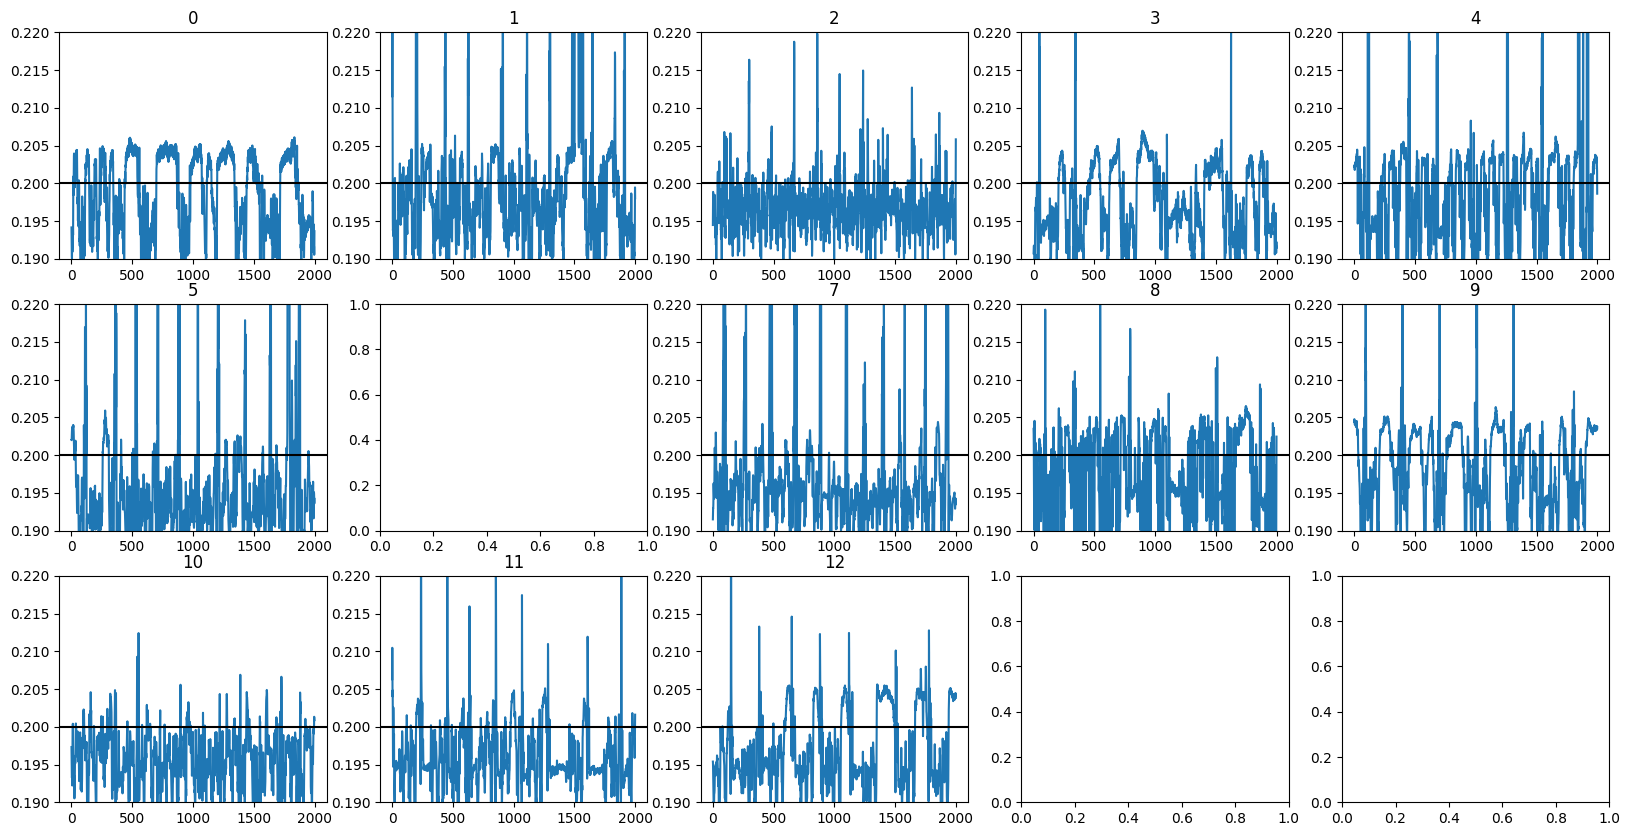

In [549]:
# process&visualise the lick data (tst)

sample_rate = 7.5
max_lick_rate = 7.5
lick_onsets_tst = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten() 

for ani in data_tst:
    lick_onsets_tst[ani] = []
    max_valid =  0.5  # upper bound for real licks vs animal pushing licktube
    lick_signal = np.clip(data_tst[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = gaussian_filter1d(lick_signal, sigma= 1, axis=0)
    
    threshold = 0.20
    
    axes[ani].plot(lick_signal[6000:8000])
    # axes[ani].plot(lick_signal)


    axes[ani].axhline(threshold, color='k')
    axes[ani].set_ylim([0.19,0.22])
    axes[ani].set_title(f'{ani}')
    above = lick_signal > threshold
    min_interval = 0.9    #  refractory period
    crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1  
    if len(crossings) > 0:
        lick_onsets_tst[ani] = [crossings[0]]
        for idx in crossings[1:]:
            if idx - lick_onsets_tst[ani][-1] >= min_interval:
                lick_onsets_tst[ani].append(idx)
        lick_onsets_tst[ani] = np.array(lick_onsets_tst[ani])
    else:
        lick_onsets_tst[ani] = np.array([])

# calculate the lick_record and lick_rate
lick_record_tst = {}
for ani in data_tst:
    lick_record_tst[ani] = np.zeros(int(data_tst[ani]['lick'].shape[0]//min_interval))
    down_sampled_lick_onsets = (lick_onsets_tst[ani]//min_interval).astype(int)
    for num in down_sampled_lick_onsets:
        lick_record_tst[ani][num] = 1

lick_rate_tst = {}
window_frames = 7
for ani in data_tst:
    lick_series = pd.Series(lick_record_tst[ani])
    # Rolling sum over 1s window
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()
    # Convert to licks/sec (since window is 1 sec, no need to change)
    lick_rate_tst[ani] = np.array(lick_count)


IndexError: index 12 is out of bounds for axis 0 with size 12

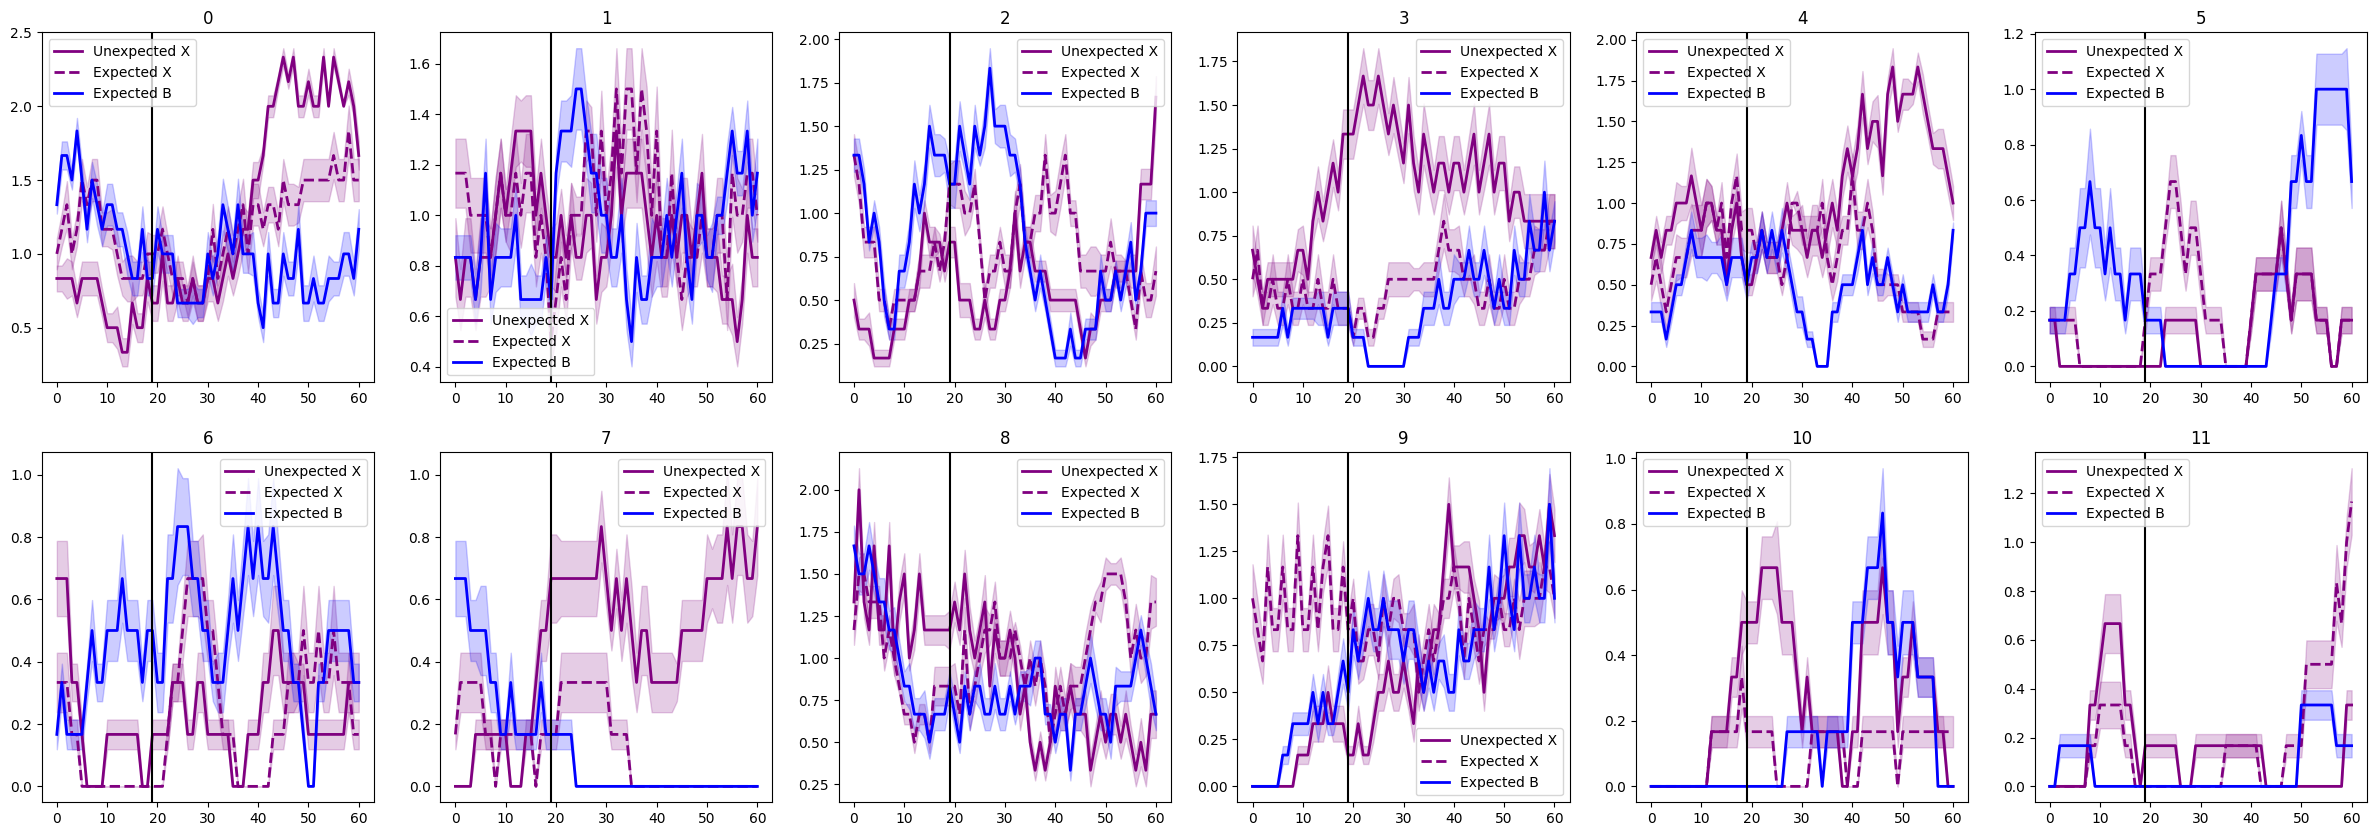

In [616]:
# Lick NEAR THE REWARD FOR EACH ANIMAL

unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_ctl[ani]['reward_indices'][trial]) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_ctl[ani]['reward_indices'][trial-1])

fig, axes = plt.subplots(2, 6, figsize=(30, 10)) 
axes = axes.flatten()
t_frames = 61
for i, ani in enumerate(data_ctl):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl[ani][unexp_rw[ani][:6]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl[ani][unexp_rw[ani][4:10]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl[ani][exp_rw[ani][:6]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([19], color='black')
    ax.set_title(f'{ani}')
    ax.legend()

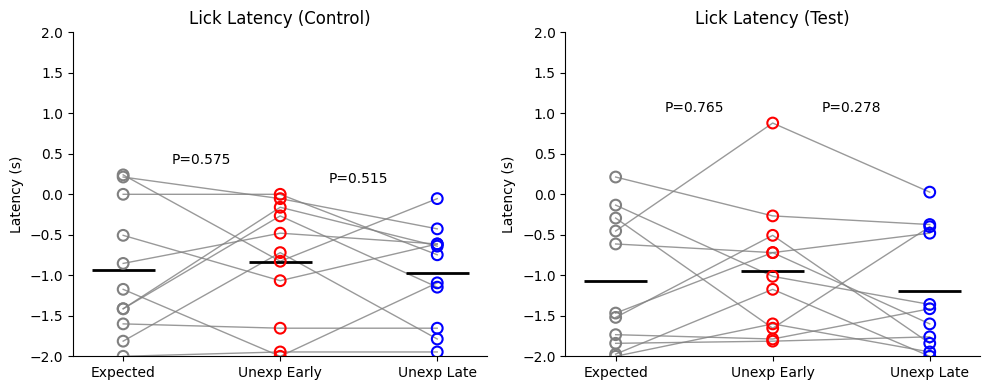

In [84]:
fps = 7.5
pre_frames = 20
post_frames = int(round(2 * fps))
reward_frame = 20
start_frame = reward_frame - pre_frames
end_frame = reward_frame + post_frames


def compute_unexp_exp_rw(data_group, group_name):
    unexp_rw = {}
    exp_rw = {}
    for ani in data_group:
        unexp_rw[ani] = []
        exp_rw[ani] = []
        for trial in data_group[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_group[ani]['reward_indices'][trial])
        if group_name == 'control':
            for trial in data_group[ani]['unpred_trials']['gr_2']:
                exp_rw[ani].append(data_group[ani]['reward_indices'][trial - 1])
        elif group_name == 'test':
            for trial in data_group[ani]['unpred_trials']['gr_2']:
                exp_rw[ani].append(data_group[ani]['reward_indices'][trial-1])
    return unexp_rw, exp_rw

unexp_rw_ctl, exp_rw_ctl = compute_unexp_exp_rw(data_ctl, 'control')
unexp_rw_tst, exp_rw_tst = compute_unexp_exp_rw(data_tst, 'test')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for num, (lick_record, unexp_rw, exp_rw) in enumerate([
    (lick_record_ctl, unexp_rw_ctl, exp_rw_ctl),
    (lick_record_tst, unexp_rw_tst, exp_rw_tst)
]):
    results = []
    all_animals = [1,3,4,5,6,7,8,9,10,11,12]
    for ani in all_animals:
        arr = lick_record[ani][exp_rw[ani][6:11]][:, start_frame:end_frame]
        first_lick_exp_B = []
        for row in arr:
            ones = np.where(row == 1)[0]
            first_lick_exp_B.append(pre_frames - ones[0] if len(ones) > 0 else -post_frames)
        arr = lick_record[ani][unexp_rw[ani][:5]][:, start_frame:end_frame]
        first_lick_unexp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]
            first_lick_unexp_X.append(pre_frames - ones[0] if len(ones) > 0 else -post_frames)
        if num == 0:
            arr = lick_record[ani][unexp_rw[ani][6:11]][:, start_frame:end_frame]
        else:
            arr = lick_record[ani][unexp_rw[ani][6:11]][:, start_frame:end_frame]
        first_lick_exp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]
            first_lick_exp_X.append(pre_frames - ones[0] if len(ones) > 0 else -post_frames)
        results.append([
            np.mean(first_lick_exp_B),
            np.mean(first_lick_unexp_X),
            np.mean(first_lick_exp_X)
        ])
    results = np.array(results) / fps
    colors = ['gray', 'red', 'blue']
    x_positions = [1, 2, 3]
    for i, xpos in enumerate(x_positions):
        ax[num].scatter(
            np.full(results.shape[0], xpos), results[:, i],
            facecolors='none', edgecolors=colors[i], s=60,
            linewidth=1.5, zorder=3
        )
    for animal in results:
        ax[num].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2)
    for i in range(results.shape[1]):
        mean_val = np.mean(results[:, i])
        ax[num].hlines(mean_val, i + 0.8, i + 1.2, color='black', linewidth=2)
    pairs = [(0, 1), (0, 2), (1, 2)]
    labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
    pvals = []
    for (i, j), label in zip(pairs, labels):
        stat, p = wilcoxon(results[:, i], results[:, j])
        pvals.append(p)
    ax[num].set_xticks([1, 2, 3])
    ax[num].set_ylim([-2,2])
    ax[num].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
    ax[num].spines['top'].set_visible(False)
    ax[num].spines['right'].set_visible(False)
    i, j = 0, 1
    x = (i + 1 + j + 1) / 2
    y = max(results[:, i].max(), results[:, j].max()) + 0.1
    ax[num].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
    i, j = 1, 2
    x = (i + 1 + j + 1) / 2
    y = max(results[:, i].max(), results[:, j].max()) + 0.1
    ax[num].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
    ax[num].set_ylabel('Latency (s)')

ax[0].set_title('Lick Latency (Control)')
ax[1].set_title('Lick Latency (Test)')
plt.tight_layout()
plt.show()


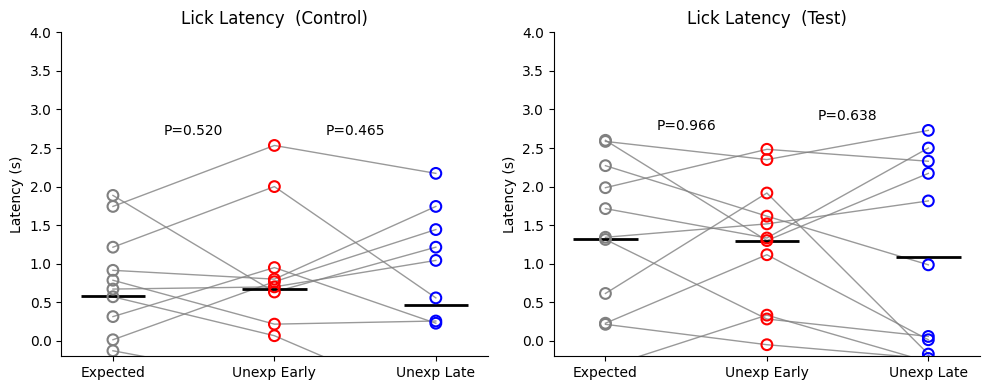

In [ ]:
# Lick latency three points plot  --- 4 seconds prior to reward

fig, ax = plt.subplots(1,2, figsize=(10,4))

for num,lick_record in enumerate([lick_record_ctl,lick_record_tst]):
    results = []
    all_animals = [1,3,4,5,6,7,8,9,10,11,12]
    
    if num == 0:
        unexp_rw = {}
        exp_rw = {}
        for ani in data_ctl:
            unexp_rw[ani] = []
            exp_rw[ani] = []
            for trial in data_ctl[ani]['unpred_trials']['gr_2']:
                    unexp_rw[ani].append(data_ctl[ani]['reward_indices'][trial]) 
            for trial in data_ctl[ani]['unpred_trials']['gr_2']:
                    exp_rw[ani].append(data_ctl[ani]['reward_indices'][trial-1])
    else:
        unexp_rw = {}
        exp_rw = {}
        for ani in data_tst:
            unexp_rw[ani] = []
            exp_rw[ani] = []
            for trial in data_tst[ani]['unpred_trials']['gr_2']:
                    unexp_rw[ani].append(data_tst[ani]['reward_indices'][trial]) 
            for trial in data_tst[ani]['unpred_trials']['gr_2']:
                    exp_rw[ani].append(data_tst[ani]['reward_indices'][trial-1])     

    for ani in all_animals:
        arr = lick_record[ani][exp_rw[ani][6:12]][:,22:38]
        first_lick_exp_B = []
        for row in arr:
            ones = np.where(row == 1)[0]   # np.where row == 1
            if len(ones) > 0:
                first_lick_exp_B.append(10 - ones[0]) 
            else:
                first_lick_exp_B.append(-10)
        arr = lick_record[ani][unexp_rw[ani][:6]][:,22:38]
        first_lick_unexp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]  
            if len(ones) > 0:
                first_lick_unexp_X.append(30 - ones[0]) 
            else:
                first_lick_unexp_X.append(-20)
        
        if num == 0:
            arr = lick_record[ani][unexp_rw[ani][20:27]][:,22:38]  
        else:
            arr = lick_record[ani][unexp_rw[ani][6:12]][:,0:50]   # test data don't have unexp trial 20-27 so use 7-14
        
        first_lick_exp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]
            if len(ones) > 0:
                first_lick_exp_X.append(30 - ones[0]) 
            else:
                first_lick_exp_X.append(-20)
        results.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
    results = np.array(results)/10  # convert frames to seconds

    colors = ['gray', 'red', 'blue']
    x_positions = [1,2,3]
    for i, xpos in enumerate(x_positions):
        ax[num].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
    for animal in results:
        ax[num].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
    for i in range(results.shape[1]):
        mean_val = np.mean(results[:, i])
        ax[num].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
    # pairwise test
    pairs = [(0,1), (0,2), (1,2)]
    labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
    pvals = []
    for (i,j), label in zip(pairs, labels):
        stat, p = wilcoxon(results[:,i], results[:,j])
        pvals.append(p)
        # print(label, "Wilcoxon p =", p)
    ax[num].set_ylim([-0.2,4])
    ax[num].set_xticks([1, 2, 3])
    ax[num].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
    ax[num].spines['top'].set_visible(False)
    ax[num].spines['right'].set_visible(False)
    i, j = 0, 1 
    x = (i+1 + j+1) / 2 
    y = max(results[:,i].max(), results[:,j].max()) + 0.1
    ax[num].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
    i, j = 1, 2 
    x = (i+1 + j+1) / 2 
    y = max(results[:,i].max(), results[:,j].max()) + 0.1  
    ax[num].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
    ax[num].set_ylabel('Latency (s)')
ax[0].set_title(f'Lick Latency  (Control)')
ax[1].set_title(f'Lick Latency  (Test)')
plt.tight_layout()
plt.show()

Speed Data

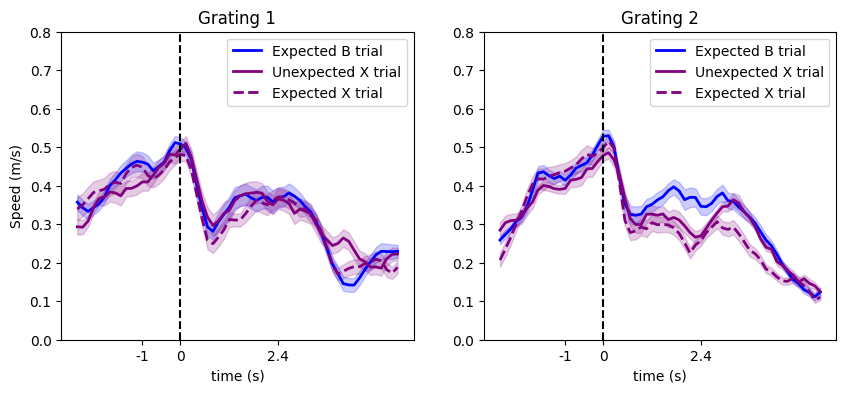

In [35]:
# Speed Averaged (Ctl)

fig,axes = plt.subplots(1,2,figsize=(10,4))

unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_1'][trial])
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_1'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][exp_grat[ani][:4]] for ani in data_ctl]), axis = 1),color='blue', alpha=0.2,  label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][unexp_grat[ani][:4]] for ani in data_ctl]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][unexp_grat[ani][6:10]] for ani in data_ctl]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style='dash')
axes[0].set_title('Grating 1')
axes[0].axvline(x=19, color='k', linestyle='--')
axes[0].set_ylabel('Speed (m/s)')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_2'][trial])
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_2'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][exp_grat[ani][:4]] for ani in data_ctl]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][unexp_grat[ani][:4]] for ani in data_ctl]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][unexp_grat[ani][6:10]] for ani in data_ctl]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style='dash')
axes[1].set_title('Grating 2')
axes[1].axvline(x=19, color='k', linestyle='--')
plt.setp(axes,ylim=[-0,0.8], xticks=[12,19,37], xticklabels=['-1','0','2.4'],xlabel='time (s)')
axes[1].legend()

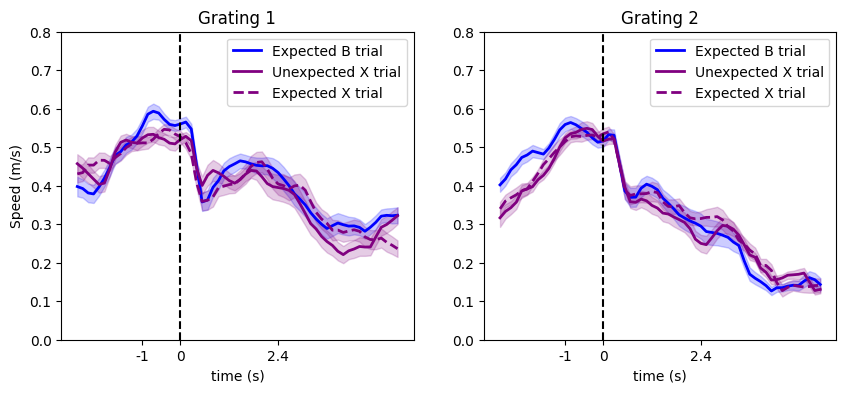

In [38]:
# Speed Averaged (tst)

fig,axes = plt.subplots(1,2,figsize=(10,4))

unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_tst[ani]['grating_indices']['gr_1'][trial])
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_tst[ani]['grating_indices']['gr_1'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][exp_grat[ani][:4]] for ani in data_tst]), axis = 1),color='blue', alpha=0.2,  label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][unexp_grat[ani][:4]] for ani in data_tst]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][unexp_grat[ani][6:10]] for ani in data_tst]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style='dash')
axes[0].set_title('Grating 1')
axes[0].axvline(x=19, color='k', linestyle='--')
axes[0].set_ylabel('Speed (m/s)')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_tst[ani]['grating_indices']['gr_2'][trial])
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_tst[ani]['grating_indices']['gr_2'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][exp_grat[ani][:4]] for ani in data_tst]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][unexp_grat[ani][:4]] for ani in data_tst]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][unexp_grat[ani][6:10]] for ani in data_tst]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style='dash')
axes[1].set_title('Grating 2')
axes[1].axvline(x=19, color='k', linestyle='--')
plt.setp(axes,ylim=[-0,0.8], xticks=[12,19,37], xticklabels=['-1','0','2.4'],xlabel='time (s)')
axes[1].legend()

In [ ]:
# Load the ctl data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\v1_ctldata.pkl")
with open(desktop_path, 'rb') as f:
    data_ = pickle.load(f)

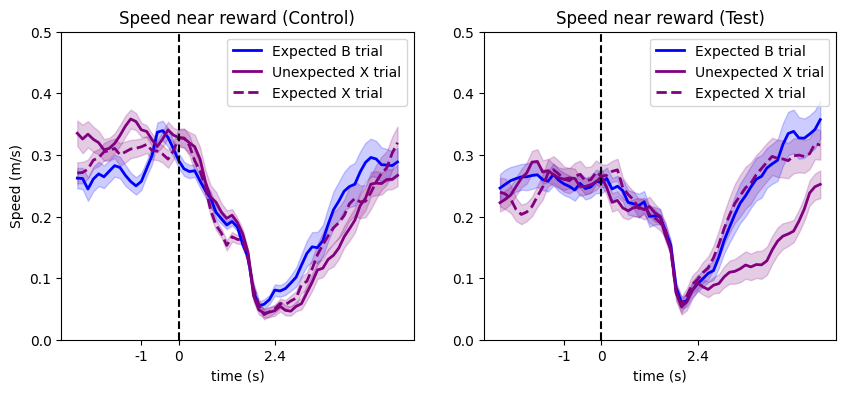

In [76]:
# Speed Averaged (ctl + tst)

fig,axes = plt.subplots(1,2,figsize=(10,4))
unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_ctl[ani]['reward_indices'][trial]) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_ctl[ani]['reward_indices'][trial-1])
t_frames = 61
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][exp_rw[ani][6:11]] for ani in data_ctl]), axis = 1),color='blue', alpha=0.2,label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][unexp_rw[ani][:5]] for ani in data_ctl]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['speed'][unexp_rw[ani][6:11]] for ani in data_ctl]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style='dash')
axes[0].set_title('Speed near reward (Control)')
axes[0].set_ylabel('Speed (m/s)')
axes[0].axvline(x=19, color='k', linestyle='--')
axes[0].legend()

unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_tst[ani]['reward_indices'][trial]) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_tst[ani]['reward_indices'][trial-1])
t_frames = 61
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][exp_rw[ani][6:11]] for ani in data_tst]), axis = 1),color='blue', alpha=0.2,label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][unexp_rw[ani][:5]] for ani in data_tst]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['speed'][unexp_rw[ani][6:11]] for ani in data_tst]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style='dash')
axes[1].set_title('Speed near reward (Test)')
axes[1].axvline(x=19, color='k', linestyle='--')
plt.setp(axes,ylim=[-0,0.5], xticks=[12,19,37], xticklabels=['-1','0','2.4'],xlabel='time (s)')
axes[1].legend()

IndexError: index 12 is out of bounds for axis 0 with size 12

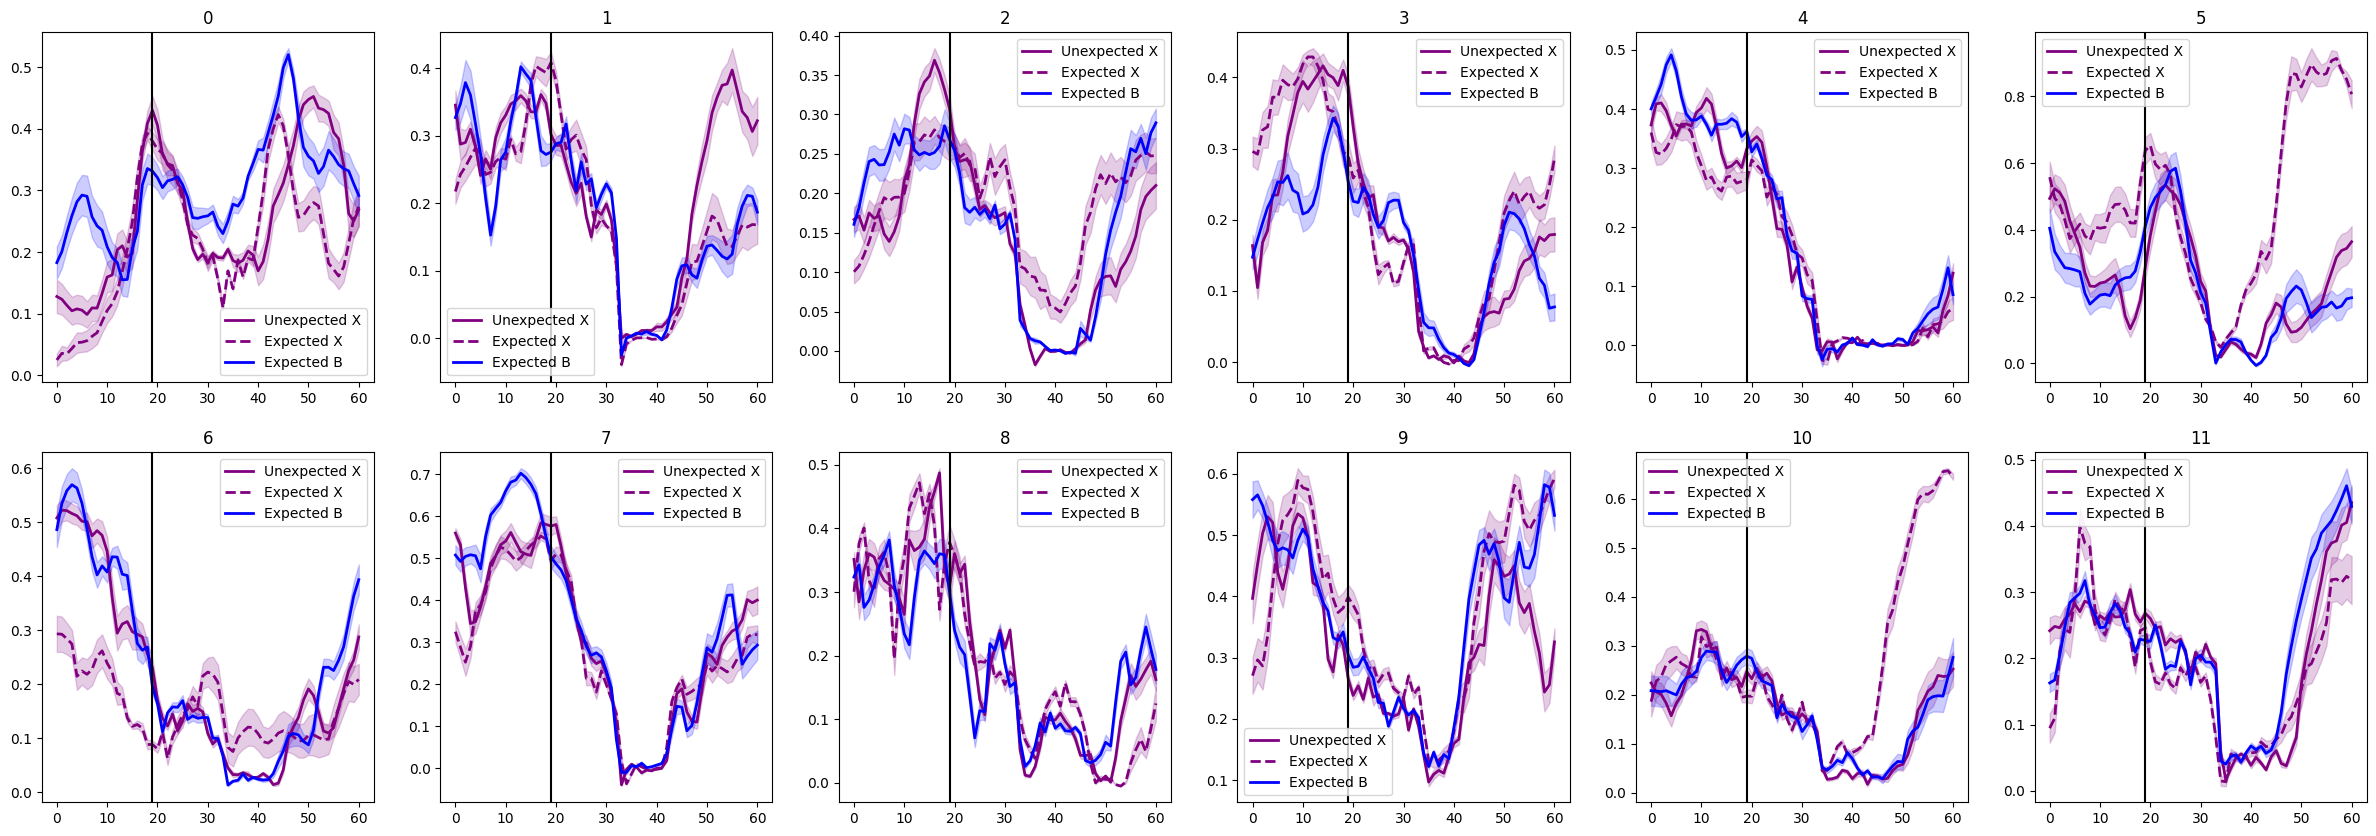

In [44]:
# SPEED NEAR THE REWARD FOR EACH ANIMAL

unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_ctl[ani]['reward_indices'][trial]) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_ctl[ani]['reward_indices'][trial-1])

fig, axes = plt.subplots(2, 6, figsize=(30, 10)) 
axes = axes.flatten()
t_frames = 61
for i, ani in enumerate(data_ctl):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['speed'][unexp_rw[ani][:7]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['speed'][unexp_rw[ani][7:14]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['speed'][exp_rw[ani][:7]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([19], color='black')
    ax.set_title(f'{ani}')
    ax.legend()

In [198]:
# Subselect animals based on average acceleration 1s prior to the reward

acc_group = [] # speed up before reward
dec_group = [] # slow down before reward

for ani in data_ctl:
    avg_acc_unexp_X = np.mean(np.mean(np.gradient(data_ctl[ani]['speed'][unexp_rw[ani][:4]][:,15:25], axis=1),axis=1),axis=0)
    avg_acc_exp_X = np.mean(np.mean(np.gradient(data_ctl[ani]['speed'][unexp_rw[ani][6:10]][:,15:25], axis=1),axis=1),axis=0)
    avg_acc_exp_B = np.mean(np.mean(np.gradient(data_ctl[ani]['speed'][exp_rw[ani][:4]][:,15:25], axis=1),axis=1),axis=0)
    if avg_acc_unexp_X+avg_acc_exp_X+avg_acc_exp_B >= 0:
        acc_group.append(ani)
    else:
        dec_group.append(ani)

print('Acc_group:', acc_group)
print('Dec_group:', dec_group)

Acc_group: []
Dec_group: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]


Pupil Data

Need X ticks labels

In [ ]:
for ani in [0,4,7,8]:
    pupil_signal = data_ctl[ani]['pupil']
    trial_start_indices = data_ctl[ani]['trial_start_indices']
    for trial in range(len(trial_start_indices)-1):
        start = trial_start_indices[trial]
        end = trial_start_indices[trial+1]
        segment = pupil_signal[start:end]
        segment = (segment-np.nanmedian(segment))/np.nanstd(segment)
        data_ctl[ani]['pupil'][start:end] = segment



In [34]:
for ani in data_tst:
    pupil_signal = data_tst[ani]['pupil']
    trial_start_indices = data_tst[ani]['trial_start_indices']
    for trial in range(len(trial_start_indices)-1):
        start = trial_start_indices[trial]
        end = trial_start_indices[trial+1]
        segment = pupil_signal[start:end]
        segment = (segment-np.nanmedian(segment))/np.nanstd(segment)
        data_tst[ani]['pupil'][start:end] = segment

In [30]:
np.array(data_ctl[0]['grating_indices']['gr_2'][0]).shape

(60,)

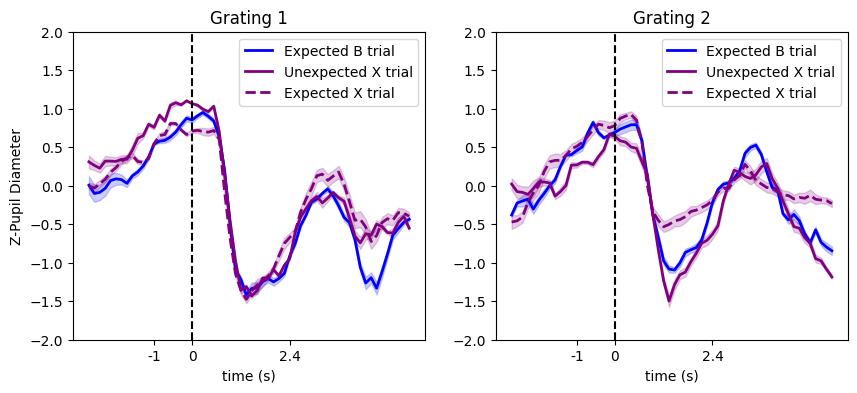

In [33]:
# Pupil Size Averaged (Ctl)

fig,axes = plt.subplots(1,2,figsize=(10,4))
unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_1'][trial])
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_1'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][exp_grat[ani][:4]] for ani in [0,4,7,8]]), axis = 1),color='blue', alpha=0.2,  label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][:4]] for ani in [0,4,7,8]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][6:10]] for ani in [0,4,7,8]]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial', style = 'dash')
axes[0].set_title('Grating 1')
axes[0].axvline(x=19, color='k', linestyle='--')
axes[0].set_ylabel('Z-Pupil Diameter')
plt.setp(axes,ylim=[-2,2], xticks=[12,19,37], xticklabels=['-1','0','2.4'],xlabel='time (s)')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_2'][trial])
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_2'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][exp_grat[ani][:4]] for ani in [0,4,7,8]]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][:4]] for ani in [0,4,7,8]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][6:10]] for ani in [0,4,7,8]]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial', style = 'dash')
axes[1].set_title('Grating 2')
axes[1].axvline(x=19, color='k', linestyle='--')
axes[1].legend()

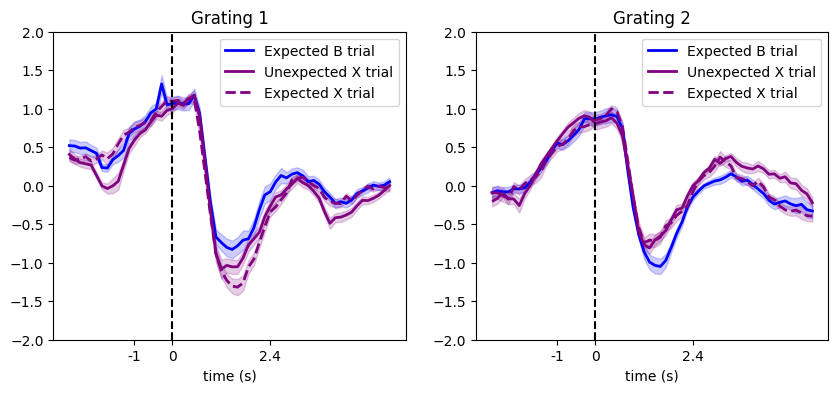

In [36]:
# Pupil Size Averaged (tst)

fig,axes = plt.subplots(1,2,figsize=(10,4))
ani_list = [1,2,3,4,5,7,8,9,10,11,12]
unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_tst[ani]['grating_indices']['gr_1'][trial])
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_tst[ani]['grating_indices']['gr_1'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][exp_grat[ani][:4]] for ani in [1,2,3,4,5,7,8,9,10,11,12]]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][:4]] for ani in [1,2,3,4,5,7,8,9,10,11,12]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][6:10]] for ani in [1,2,3,4,5,7,8,9,10,11,12]]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial', style = 'dash')
axes[0].set_title('Grating 1')
axes[0].axvline(x=19, color='k', linestyle='--')
plt.setp(axes,ylim=[-2,2], xticks=[12,19,37], xticklabels=['-1','0','2.4'],xlabel='time (s)')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_tst[ani]['grating_indices']['gr_2'][trial])
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_tst[ani]['grating_indices']['gr_2'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][exp_grat[ani][:4]] for ani in [1,2,3,4,5,7,8,9,10,11,12]]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][:4]] for ani in [1,2,3,4,5,7,8,9,10,11,12]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][6:10]] for ani in [1,2,3,4,5,7,8,9,10,11,12]]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial', style = 'dash')
axes[1].set_title('Grating 2')
axes[1].axvline(x=19, color='k', linestyle='--')
axes[1].legend()

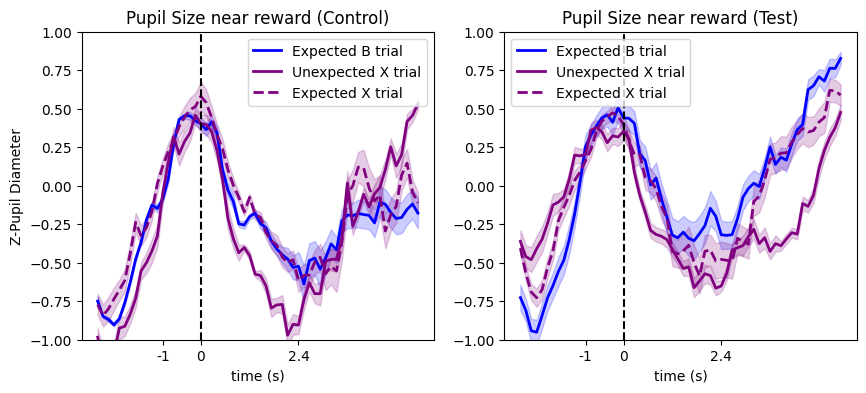

In [41]:
# Pupil Size Averaged (Ctl & Tst) 

fig,axes = plt.subplots(1,2,figsize=(10,4))
unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_ctl[ani]['reward_indices'][trial]) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_ctl[ani]['reward_indices'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][exp_rw[ani][6:11]] for ani in [0,4,7,8]]), axis = 1),color='blue', alpha=0.2,label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_rw[ani][:5]] for ani in [0,4,7,8]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_rw[ani][6:11]] for ani in [0,4,7,8]]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style = 'dash')
axes[0].set_title('Pupil Size near reward (Control)')
# axes[0].set_xlim([10,40])
axes[0].axvline(x=19, color='k', linestyle='--')
axes[0].legend()

unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_tst[ani]['reward_indices'][trial]) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_tst[ani]['reward_indices'][trial-1])
t_frames = 60
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][exp_rw[ani][6:11]] for ani in [1,3,4,5,7,9,10]]), axis = 1),color='blue', alpha=0.2,label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_rw[ani][:5]] for ani in [1,3,4,5,7,9,10]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_rw[ani][6:11]] for ani in [1,3,4,5,7,9,10]]), axis = 1),color='purple', alpha=0.2,label= 'Expected X trial',style = 'dash')
axes[1].set_title('Pupil Size near reward (Test)')
axes[1].axvline(x=19, color='k', linestyle='--')
# axes[1].set_xlim([10,40])
axes[0].set_ylabel('Z-Pupil Diameter')
plt.setp(axes,ylim=[-1,1], xticks=[12,19,37], xticklabels=['-1','0','2.4'],xlabel='time (s)')
axes[1].legend()


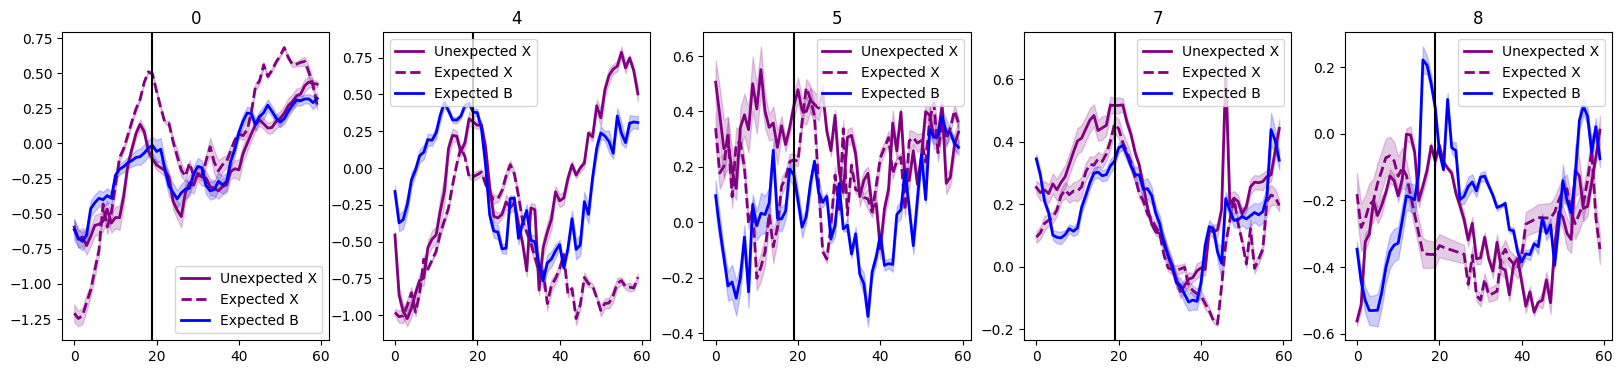

In [176]:
# Pupil Size near reward (Control)
unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_ctl[ani]['reward_indices'][trial]) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_ctl[ani]['reward_indices'][trial-1])

fig, axes = plt.subplots(1, 5, figsize=(20, 4)) 
axes = axes.flatten()
t_frames = 60
for i, ani in enumerate([0,4,5,7,8]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][unexp_rw[ani][:4]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][unexp_rw[ani][6:10]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][exp_rw[ani][:4]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([19], color='black')
    ax.set_title(f'{ani}')
    ax.legend()


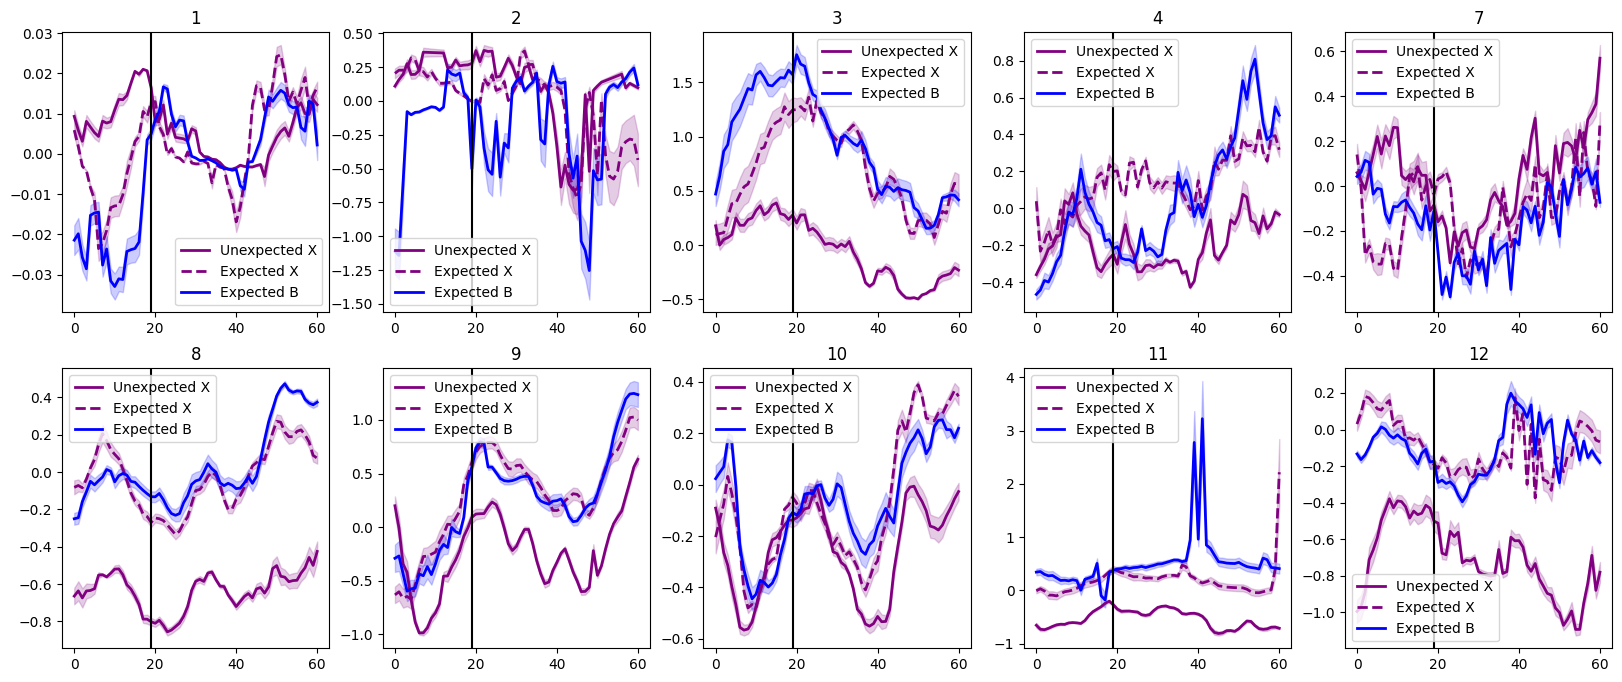

In [ ]:
# Pupil Size near reward (Test)
unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_tst[ani]['reward_indices'][trial]) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_tst[ani]['reward_indices'][trial-1])

fig, axes = plt.subplots(2, 5, figsize=(20, 8)) 
axes = axes.flatten()
t_frames = 61
for i, ani in enumerate([1,2,3,4,7,8,9,10,11,12]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_rw[ani][:5]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_rw[ani][6:11]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][exp_rw[ani][6:11]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([19], color='black')
    ax.set_title(f'{ani}')
    ax.legend()



plt.subplot(8,)
for ani in data_tst:
      af.plot_shaded_error()